In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [1]:
import fastai
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)
import pandas as pd
import numpy as np
from tqdm import tqdm
from random import *

pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
PATH='Utah/'

In [2]:
from glob import glob

In [5]:
dfs = [pd.read_pickle(file) for file in glob('samples_*.pkl')]

In [6]:
samples = pd.DataFrame()

In [8]:
samples = samples.append(dfs, ignore_index=True)

In [9]:
samples.shape

(1370992, 169)

In [10]:
add_datepart(samples, "datetime", drop=False)

In [11]:
cat_vars = ['FC_NAME', 'REGION', 'ROADWAYJUNCTFEATUREID', 'ROADWAYTYPECD', 
            'ROUTEDIRECTION', 'RouteName','SAF_INDEX',
            'State_FA', 'Station ID_x', 'hour_x', 'year_x','wind_cardinal_direction_set_1d',
             'datetimeMonth',
             'datetimeWeek',
             'datetimeDay',
             'datetimeDayofweek',
             'datetimeDayofyear',

             'datetimeIs_month_end',
             'datetimeIs_month_start',
             'datetimeIs_quarter_end',
             'datetimeIs_quarter_start',
             'datetimeIs_year_end',
             'datetimeIs_year_start']

contin_vars = ['AVG_AADT', 'AvE_CRT', 'AvE_SEV_CR', 'EXP_CRT', 'EXP_SEV_CR',
   'SEV_CRT', 'SEV_C_MI', 'TOT_C', 'TOT_SEV_C', 
   'wind_gust_set_1', 'wind_direction_set_1', 'relative_humidity_set_1', 
   'dew_point_temperature_set_1d', 'wind_speed_set_1', 'air_temp_set_1']

n = len(samples); n

1370992

In [12]:
train = samples.sample(frac=0.75,random_state=200)
test  = samples.drop(train.index)

In [13]:
dep = 'class' #target class = 0 for no accident, 1 for accident
train = train[cat_vars+contin_vars+[dep]].copy() 
test = test[cat_vars+contin_vars+[dep]].copy()

### Data Preparation (Create Dummies, Normalize...)

In [48]:
train.head(2)

,FC_NAME,REGION,ROADWAYJUNCTFEATUREID,ROADWAYTYPECD,ROUTEDIRECTION,RouteName,SAF_INDEX,State_FA,Station ID_x,hour_x,year_x,wind_cardinal_direction_set_1d,datetimeMonth,datetimeWeek,datetimeDay,datetimeDayofweek,datetimeDayofyear,datetimeIs_month_end,datetimeIs_month_start,datetimeIs_quarter_end,datetimeIs_quarter_start,datetimeIs_year_end,datetimeIs_year_start,AVG_AADT,AvE_CRT,AvE_SEV_CR,EXP_CRT,EXP_SEV_CR,SEV_CRT,SEV_C_MI,TOT_C,TOT_SEV_C,wind_gust_set_1,wind_direction_set_1,relative_humidity_set_1,dew_point_temperature_set_1d,wind_speed_set_1,air_temp_set_1,class
958041,Urban Principal Arterial,1,No Special Feature/Junction,Mainline,P,0108P,4,State,KOGD,19,2015,NaN,2.0,8.0,17.0,1.0,48.0,False,False,False,False,False,False,13365.0,1.909336,0.0,2.74,6.8,0.0,0.0,49.0,0.0,NaN,NaN,34.330002,-9.04,2.06,5.6,0
903491,Urban Minor Arterial,3,No Special Feature/Junction,Mainline,P,2881P,1,FA,C6171,8,2015,NaN,11.0,48.0,28.0,5.0,332.0,False,False,False,False,False,False,16340.0,0.092404,0.0,3.40,8.6,0.0,0.0,19.0,0.0,2.68,NaN,66.000000,-10.44,0.00,-5.0,1


In [14]:
for v in cat_vars:
    train[v] = train[v].astype('category').cat.as_ordered()

In [15]:
apply_cats(test, train)

In [16]:
for v in contin_vars:
    train[v] = train[v].astype('float32')
    test[v]  = test[v].astype('float32')

In [17]:
samp_size = n
joined_samp = train

In [18]:
joined_samp.head(2)

,FC_NAME,REGION,ROADWAYJUNCTFEATUREID,ROADWAYTYPECD,ROUTEDIRECTION,RouteName,SAF_INDEX,State_FA,Station ID_x,hour_x,year_x,wind_cardinal_direction_set_1d,datetimeMonth,datetimeWeek,datetimeDay,datetimeDayofweek,datetimeDayofyear,datetimeIs_month_end,datetimeIs_month_start,datetimeIs_quarter_end,datetimeIs_quarter_start,datetimeIs_year_end,datetimeIs_year_start,AVG_AADT,AvE_CRT,AvE_SEV_CR,EXP_CRT,EXP_SEV_CR,SEV_CRT,SEV_C_MI,TOT_C,TOT_SEV_C,wind_gust_set_1,wind_direction_set_1,relative_humidity_set_1,dew_point_temperature_set_1d,wind_speed_set_1,air_temp_set_1,class
958041,Urban Principal Arterial,1,No Special Feature/Junction,Mainline,P,0108P,4,State,KOGD,19,2015,NaN,2.0,8.0,17.0,1.0,48.0,False,False,False,False,False,False,13365.0,1.909336,0.0,2.74,6.8,0.0,0.0,49.0,0.0,NaN,NaN,34.330002,-9.04,2.06,5.6,0
903491,Urban Minor Arterial,3,No Special Feature/Junction,Mainline,P,2881P,1,FA,C6171,8,2015,NaN,11.0,48.0,28.0,5.0,332.0,False,False,False,False,False,False,16340.0,0.092404,0.0,3.40,8.6,0.0,0.0,19.0,0.0,2.68,NaN,66.000000,-10.44,0.00,-5.0,1


In [19]:
df, y, nas, mapper = proc_df(joined_samp, 'class', do_scale=True)

In [20]:
df_test, y_test, nas, mapper = proc_df(test, 'class', do_scale=True, 
                                  mapper=mapper, na_dict=nas)

In [21]:
df.shape, df_test.shape

((1028244, 44), (342748, 44))

In [22]:
df.head(2)

,FC_NAME,REGION,ROADWAYJUNCTFEATUREID,ROADWAYTYPECD,ROUTEDIRECTION,RouteName,SAF_INDEX,State_FA,Station ID_x,hour_x,year_x,wind_cardinal_direction_set_1d,datetimeMonth,datetimeWeek,datetimeDay,datetimeDayofweek,datetimeDayofyear,datetimeIs_month_end,datetimeIs_month_start,datetimeIs_quarter_end,datetimeIs_quarter_start,datetimeIs_year_end,datetimeIs_year_start,AVG_AADT,AvE_CRT,AvE_SEV_CR,EXP_CRT,EXP_SEV_CR,SEV_CRT,SEV_C_MI,TOT_C,TOT_SEV_C,wind_gust_set_1,wind_direction_set_1,relative_humidity_set_1,dew_point_temperature_set_1d,wind_speed_set_1,air_temp_set_1,wind_gust_set_1_na,wind_direction_set_1_na,relative_humidity_set_1_na,dew_point_temperature_set_1d_na,wind_speed_set_1_na,air_temp_set_1_na
958041,12,1,9,2,2,102,5,2,177,20,6,0,2,8,17,2,48,1,1,1,1,1,1,-0.492793,0.678869,-0.793926,0.090743,0.108338,-0.695297,-0.854624,-0.548472,-0.935319,-0.206485,-0.027014,-0.950992,-0.572637,-0.032235,-0.450130,1.141999,1.727705,-0.592152,-0.593265,-0.466603,-0.417499
903491,10,3,9,2,2,706,2,1,46,9,6,0,11,48,28,6,332,1,1,1,1,1,1,-0.430656,-1.243416,-0.793926,0.677040,0.778433,-0.695297,-0.854624,-0.744161,-0.935319,-0.376757,-0.027014,0.558271,-0.665326,-0.999820,-1.458302,-0.875657,1.727705,-0.592152,-0.593265,-0.466603,-0.417499


In [23]:
train_ratio = 0.60
# train_ratio = 0.9
train_size = int(samp_size * train_ratio); 
print(train_size)
val_idx = list(range(train_size, len(df)))

822595


In [24]:
len(val_idx)

205649

In [25]:
len(df), len(y)

(1028244, 1028244)

In [26]:
len(df_test), len(y_test)

(342748, 342748)

### DNN Classifier

In [27]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, y, cat_flds=cat_vars, 
                                       bs=128, test_df=df_test)

In [28]:
cat_sz = [(c, len(joined_samp[c].cat.categories)+1) for c in cat_vars]
cat_sz

[('FC_NAME', 13),
 ('REGION', 5),
 ('ROADWAYJUNCTFEATUREID', 21),
 ('ROADWAYTYPECD', 3),
 ('ROUTEDIRECTION', 3),
 ('RouteName', 885),
 ('SAF_INDEX', 12),
 ('State_FA', 3),
 ('Station ID_x', 376),
 ('hour_x', 26),
 ('year_x', 9),
 ('wind_cardinal_direction_set_1d', 17),
 ('datetimeMonth', 13),
 ('datetimeWeek', 54),
 ('datetimeDay', 32),
 ('datetimeDayofweek', 8),
 ('datetimeDayofyear', 367),
 ('datetimeIs_month_end', 3),
 ('datetimeIs_month_start', 3),
 ('datetimeIs_quarter_end', 3),
 ('datetimeIs_quarter_start', 3),
 ('datetimeIs_year_end', 3),
 ('datetimeIs_year_start', 3)]

In [29]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]
emb_szs

[(13, 7),
 (5, 3),
 (21, 11),
 (3, 2),
 (3, 2),
 (885, 50),
 (12, 6),
 (3, 2),
 (376, 50),
 (26, 13),
 (9, 5),
 (17, 9),
 (13, 7),
 (54, 27),
 (32, 16),
 (8, 4),
 (367, 50),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2)]

In [30]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01]) #, y_range=y_range)
lr = 1e-3

In [31]:
m.lr_find()

 56%|█████▌    | 3614/6427 [00:43<00:33, 83.33it/s, loss=22.4] 

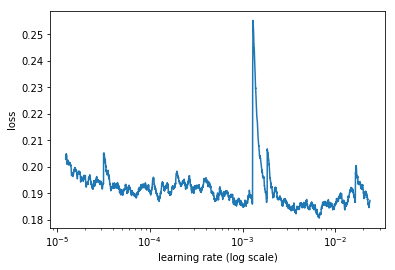

 56%|█████▌    | 3614/6427 [01:00<00:46, 60.17it/s, loss=22.4]

In [32]:
m.sched.plot(100)

In [33]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01]) #, y_range=y_range)
lr = 5e-4

In [ ]:
m.fit(lr, 1, metrics=[accuracy])

In [35]:
m.fit(lr, 3, metrics=[accuracy])

[0.      0.18258 0.18174 0.75038]                              
[1.      0.17846 0.18162 0.75038]                              
[2.      0.18211 0.18171 0.75038]                              



In [36]:
m.fit(lr, 3, metrics=[accuracy], cycle_len=1)

[0.      0.17974 0.18186 0.75038]                              
[1.      0.18099 0.18217 0.75038]                              
[2.      0.18128 0.18244 0.75038]                              



In [37]:
xy,yy = m.predict_with_targs()

In [40]:
accuracy(xy,yy)

0.7504291292444893

In [41]:
pred_test = m.predict(True)

In [42]:
accuracy(pred_test, y_test)

0.7495798662574252

## RandomForestClassifier

In [43]:
from sklearn.ensemble import RandomForestClassifier

In [44]:
len(df.values), len(y)

(1028244, 1028244)

In [45]:
((val,trn), (y_val,y_trn)) = split_by_idx(val_idx, df.values, y)

In [46]:
m = RandomForestClassifier(n_estimators=40, max_features=0.99, min_samples_leaf=2,
                          n_jobs=-1, oob_score=True)
m.fit(trn, y_trn);

In [47]:
preds = m.predict(val)
m.score(trn, y_trn), m.score(val, y_val), m.oob_score_ #, exp_rmspe(preds, y_val)

(0.8204936815808509, 0.6388749762945601, 0.6300731222533568)